In [1]:
# Competition: Loan Approval Prediction
# Link: https://www.kaggle.com/competitions/playground-series-s4e10
import kagglehub
import kagglehub.auth
import polars as pl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
loan_approval_train = kagglehub.competition_download(
    "playground-series-s4e10", path="train.csv"
)
loan_approval_train_data = pl.read_csv(loan_approval_train)
loan_approval_train_data.head()

id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
i64,i64,i64,str,f64,str,str,i64,f64,f64,str,i64,i64
0,37,35000,"""RENT""",0.0,"""EDUCATION""","""B""",6000,11.49,0.17,"""N""",14,0
1,22,56000,"""OWN""",6.0,"""MEDICAL""","""C""",4000,13.35,0.07,"""N""",2,0
2,29,28800,"""OWN""",8.0,"""PERSONAL""","""A""",6000,8.9,0.21,"""N""",10,0
3,30,70000,"""RENT""",14.0,"""VENTURE""","""B""",12000,11.11,0.17,"""N""",5,0
4,22,60000,"""RENT""",2.0,"""MEDICAL""","""A""",6000,6.92,0.1,"""N""",3,0


In [3]:
df_0 = loan_approval_train_data.filter(loan_status=0)
df_1 = loan_approval_train_data.filter(loan_status=1)
df_0 = df_0.sample(n=df_1.height, shuffle=True, seed=42)  # Balance the dataset
df = pl.concat([df_0, df_1])
df = df.drop("id")
features = df[:, :-1]
labels = df[:, -1]
print(features.shape, labels.shape)
df.head()

(16700, 11) (16700,)


person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
i64,i64,str,f64,str,str,i64,f64,f64,str,i64,i64
27,42000,"""RENT""",3.0,"""EDUCATION""","""C""",3000,13.8,0.07,"""N""",8,0
23,110000,"""MORTGAGE""",7.0,"""MEDICAL""","""B""",5000,11.49,0.05,"""N""",4,0
21,42000,"""RENT""",5.0,"""DEBTCONSOLIDATION""","""B""",6000,9.99,0.14,"""N""",3,0
30,37000,"""RENT""",0.0,"""DEBTCONSOLIDATION""","""B""",6000,9.99,0.16,"""N""",10,0
26,51600,"""RENT""",0.0,"""MEDICAL""","""C""",1500,14.35,0.03,"""N""",4,0


In [4]:
def clean(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns(
        loan_grade=16 - pl.col("loan_grade").str.to_integer(base=32),
        cb_person_default_on_file=pl.when(pl.col("cb_person_default_on_file") == "Y")
        .then(1)
        .otherwise(0),
    )
    df = df.to_dummies(["person_home_ownership", "loan_intent"])
    return df


data = clean(features).to_torch().float()
labels = labels.to_torch().long()
print(data.shape, data.min(), data.max())
print(labels.shape, labels.min(), labels.max())

torch.Size([16700, 19]) tensor(0.) tensor(948000.)
torch.Size([16700]) tensor(0) tensor(1)


In [5]:
train_data, val_data, train_labels, val_labels = train_test_split(
    data, labels, test_size=0.2, random_state=42
)
val_data, test_data, val_labels, test_labels = train_test_split(
    val_data, val_labels, test_size=0.5, random_state=42
)
train_data = train_data / torch.max(train_data)
val_data = val_data / torch.max(val_data)
test_data = test_data / torch.max(test_data)

train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 32
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)
val_loader = DataLoader(val_dataset, batch_size=val_dataset.tensors[0].shape[0])
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

print(f"train_data: {train_dataset.tensors[0].dtype}")
print(f"train_labels: {train_dataset.tensors[1].dtype}")
print(f"val_data: {val_dataset.tensors[0].dtype}")
print(f"val_labels: {val_dataset.tensors[1].dtype}")
print(f"test_data: {test_dataset.tensors[0].dtype}")
print(f"test_labels: {test_dataset.tensors[1].dtype}")

train_data: torch.float32
train_labels: torch.int64
val_data: torch.float32
val_labels: torch.int64
test_data: torch.float32
test_labels: torch.int64


In [6]:
print(f"Training data range {train_data.min()} - {train_data.max()}")
print(f"Val data range {val_data.min()} - {val_data.max()}")
print(f"Test data range {test_data.min()} - {test_data.max()}")

Training data range 0.0 - 1.0
Val data range 0.0 - 1.0
Test data range 0.0 - 1.0


In [7]:
class LoanApprovalModel(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.input = nn.Linear(input_dim, 64)
        self.fc1 = nn.Linear(64, 16)
        self.output = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = self.output(x)
        return torch.log_softmax(x, dim=1)


def create_model(input_dim: int = 19, learning_rate=0.001) -> tuple:
    model = LoanApprovalModel(input_dim)
    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    return model, loss_fn, optimizer

In [8]:
def train_model(epochs: int = 100, learning_rate: float = 0.001):
    model, loss_fn, optimizer = create_model(input_dim=train_data.shape[1], learning_rate=learning_rate)
    losses = torch.zeros(epochs, 2)
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        batch_losses = []
        batch_accuracies = []
        for X, y in train_loader:
            # forward pass
            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate accuracy
            batch_losses.append(loss.item())
            matches = (y_hat.argmax(dim=1) == y).float()
            batch_accuracies.append(100 * matches.mean().item())

        train_accuracy = np.mean(batch_accuracies)
        losses[epoch, 0] = np.mean(batch_losses)

        X, y = next(iter(val_loader))
        with torch.no_grad():
            y_hat = model(X)
        val_accuracies.append(100 * (y_hat.argmax(dim=1) == y).float().mean().item())
        val_loss = loss_fn(y_hat, y)
        losses[epoch, 1] = val_loss.item()

        print(
            f"Epoch {epoch + 1}/{epochs}, Train Loss: {losses[epoch, 0]:.4f}, Val Loss: {losses[epoch, 1]:.4f}"
        )

    return train_accuracies, val_accuracies, losses, model

In [9]:
train_accuracies, val_accuracies, losses, model = train_model(
    epochs=1000, learning_rate=0.0001
)

Epoch 1/1000, Train Loss: 0.6947, Val Loss: 0.6917
Epoch 2/1000, Train Loss: 0.6925, Val Loss: 0.6893
Epoch 3/1000, Train Loss: 0.6911, Val Loss: 0.6860
Epoch 4/1000, Train Loss: 0.6892, Val Loss: 0.6807
Epoch 5/1000, Train Loss: 0.6861, Val Loss: 0.6765
Epoch 6/1000, Train Loss: 0.6815, Val Loss: 0.6718
Epoch 7/1000, Train Loss: 0.6753, Val Loss: 0.6725
Epoch 8/1000, Train Loss: 0.6676, Val Loss: 0.6788
Epoch 9/1000, Train Loss: 0.6594, Val Loss: 0.7005
Epoch 10/1000, Train Loss: 0.6512, Val Loss: 0.7173
Epoch 11/1000, Train Loss: 0.6438, Val Loss: 0.7477
Epoch 12/1000, Train Loss: 0.6372, Val Loss: 0.7837
Epoch 13/1000, Train Loss: 0.6316, Val Loss: 0.8224
Epoch 14/1000, Train Loss: 0.6269, Val Loss: 0.8765
Epoch 15/1000, Train Loss: 0.6229, Val Loss: 0.8927
Epoch 16/1000, Train Loss: 0.6194, Val Loss: 0.9181
Epoch 17/1000, Train Loss: 0.6164, Val Loss: 0.9284
Epoch 18/1000, Train Loss: 0.6136, Val Loss: 0.9369
Epoch 19/1000, Train Loss: 0.6106, Val Loss: 0.9745
Epoch 20/1000, Train 

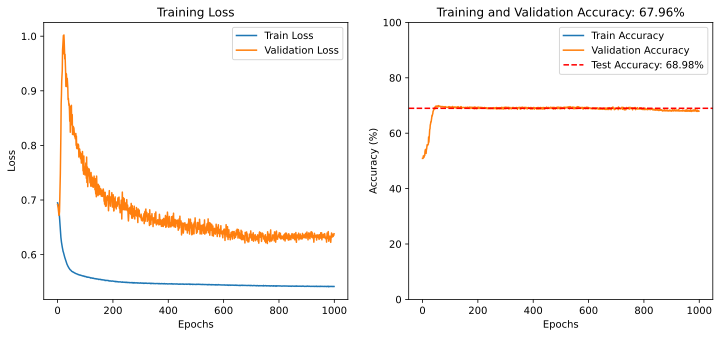

In [10]:
# Calculate test accuracy
X_test, y_test = next(iter(test_loader))
with torch.no_grad():
    y_pred = model(X_test)
test_accuracy = 100 * (y_pred.argmax(dim=1) == y_test).float().mean().item()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(losses, label="Train Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Training Loss")
ax[0].legend(["Train Loss", "Validation Loss"])

ax[1].plot(train_accuracies, label="Train Accuracy")
ax[1].plot(val_accuracies, label="Validation Accuracy")
ax[1].axhline(
    test_accuracy,
    color="red",
    linestyle="--",
    label=f"Test Accuracy: {test_accuracy:.2f}%",
)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(f"Training and Validation Accuracy: {val_accuracies[-1]:.2f}%")
ax[1].set_ylim(0, 100)
ax[1].legend() 